In [1]:
(require '[clojupyter.misc.helper :as helper])
(def _ (helper/add-dependencies '[org.mentat/emmy "0.32.0"]))

#'user/_

In [2]:
(def _ (helper/add-dependencies '[org.scicloj/kindly  "4-beta14"]))
(def _ (helper/add-dependencies '[org.scicloj/kindly-advice  "1-beta12"]))

#'user/_

In [3]:
(ns emmy-sicm-ch01
    (:refer-clojure :exclude [+ - * / zero? compare divide numerator denominator infinite? abs ref partial =])
    (:require [clojure.spec.alpha :as s]
              [clojure.spec.test.alpha :as ts]
              [emmy.env :refer :all :exclude [r->p]]
              [emmy.mechanics.lagrange :as lg]
              [emmy.numerical.minimize :as mn]
              [scicloj.kindly.v4.kind :as kind]))

nil

## 1.4 Computing Actions

The following examples are taken from the open-access book [Structure and Interpretation of Classical Mechanics (SICM)](https://mitp-content-server.mit.edu/books/content/sectbyfn/books_pres_0/9579/sicm_edition_2.zip/chapter001.html). First task: Calculate the action for the free particle along a path. Consider the particle moving at uniform speed along a straight line.

In [4]:
(defn test-path
  "See p. 20"
  [t]
  (up (+ (* 4 t) 7)
      (+ (* 3 t) 5)
      (+ (* 2 t) 1)))

(Lagrangian-action (lg/L-free-particle 3.0) test-path 0.0 10.0)

435.0

#### Paths of minimum Action

Show that the action is smaller along a straight-line test path than along nearby paths

In [5]:
(defn make-η
  "See p. 21"
  [ν t1 t2]
  (fn [t]
    (* (- t t1) (- t t2) (ν t))))

(defn varied-free-particle-action
  "See p. 21"
  [mass q ν t1 t2]
  (fn [ε]
    (let [η (make-η ν t1 t2)]
      (Lagrangian-action (lg/L-free-particle mass)
                         (+ q (* ε η)) t1 t2))))
             
((varied-free-particle-action 3.0 test-path (up sin cos square) 0.0 10.0) 0.01)

564.1214285776678

Simulate lots of the paths in this manner. Proof that the minimum value of the action is the action along the straight path. For this proof it suffices that some optimization parameter is close to zero (need not be exactly zero).

In [6]:
(minimize (varied-free-particle-action 3.0 test-path (up sin cos square) 0.0 10.0) -2 1)

:result 2.9802238177427906E-8 :value 434.9999477302537 :iterations 19 :converged? true :fncalls 20

I provide some helper functions for visualization:

In [7]:
(defn points->plot [paths x-axis-name y-axis-name]
 (let [coord-encoding (fn [coord] {:field coord :type "quantitative" :scale {:zero false}})
       paths-to-data (flatten 
                         (map (fn [[id data]] 
                                  (map (fn [[t x y z]] 
                                           {:id id :t t :x x :y y :z z}) data)) paths))]
  {:$schema "https://vega.github.io/schema/vega-lite/v2.json"
   :data {:values paths-to-data}
   :encoding 
     {:x (coord-encoding x-axis-name) 
      :y (coord-encoding y-axis-name)}
   :layer
   [{:mark "line"
     :encoding
     {:order {:field "t" :type "temporal"}
      :color {:field "id" :type "nominal"}}}
    {:mark {:type "point" :filled true}}]}))

(defn alt-range [t0 t1 nofsteps]
    (map float (flatten [t0 (linear-interpolants t0 t1 (- nofsteps 2)) t1])))

(defn make-path-txyz [fn_t t0 t1 nofsteps]
  (mapv #(cons % (.v (fn_t %)))
    (alt-range t0 t1 nofsteps)))

(defn points-xy->plot [paths] 
  (points->plot paths "x" "y"))

(defn points-xz->plot [paths] 
  (points->plot paths "x" "z"))

(defn points-tz->plot [paths] 
  (points->plot paths "t" "z"))

#'emmy-sicm-ch01/points-tz->plot

In [8]:
(comment 
 (def werte {"sb" [[0 7 5 1] [1 11 8 10]]
            "uv" [[2 9 2 4] [3 3  9 7]]})

(kind/vega-lite (points-xz->plot werte)))

nil

Create data to plot two straight paths in the xy plane. One path is along the x axis (name: path-along-x), the second path leads in all directions.

In [9]:
(defn path-along-x
  [t]
  (up (+ (* 5 t) 1)
      (* 0 t)
      (* 0 t)))

(def path-points-1 {"a straight x" (make-path-txyz path-along-x 0 10 8)
                    "b book" (make-path-txyz test-path 0 10 8)})

#'emmy-sicm-ch01/path-points-1

Plot the two paths

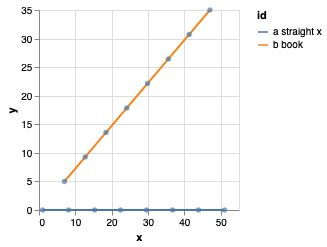

In [10]:
(-> (points-xy->plot path-points-1)
    kind/vega-lite)

Create two variations of the path-along-x. Calculate the action. Show once again that the Lagrangian-action is indeed smallest for the straight path.

In [11]:
(defn make-varied-path [ε t0 t1]
 (+ path-along-x (* ε (make-η (up #(* 0 %) identity #(* 5.0 (sin %))) t0 t1))))

(def small-varied-path (make-varied-path 0.01 0 10))
(def large-varied-path (make-varied-path 0.02 0 10))

[(Lagrangian-action (lg/L-free-particle 3.0) path-along-x 0.0 10.0)
 (Lagrangian-action (lg/L-free-particle 3.0) small-varied-path 0.0 10.0)
 (Lagrangian-action (lg/L-free-particle 3.0) large-varied-path 0.0 10.0)]

375.0 383.8260332333053 410.30413299914085

Create data to plot the three paths in the xz plane along with their actions.

In [12]:
(def path-points-2
    {"path-along-x" (make-path-txyz path-along-x 0 10 8)
     "small-varied-path" (make-path-txyz small-varied-path 0 10 24)
     "large-varied-path" (make-path-txyz large-varied-path 0 10 32)})

#'emmy-sicm-ch01/path-points-2

Plot the three paths.

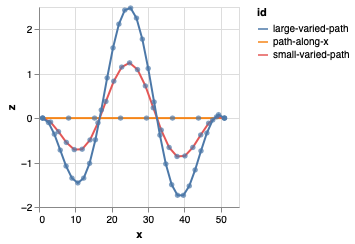

In [13]:
(-> (points-xz->plot path-points-2)
    kind/vega-lite)

#### Finding trajectories that minimize the action

The SICM library provides a procedure that constructs a one dimensional path (along, say, the z axis) using an interpolation polynomial: `(make-path t0 q0 t1 q1 qs)`, where q0 and q1 are the endpoints, t0 and t1 are the corresponding times, and qs is a list of intermediate points. I give an example (note that the result, `initial-path`, is itself a function):

In [14]:
(def pi-half (* 0.5 Math/PI))
(def initial-qs [0.1 0.2 0.2])
(def initial-path (lg/make-path 0 1.0 pi-half 0.0 initial-qs))

#'emmy-sicm-ch01/initial-path

Construct a parametric action that is just the action computed along that parametric path. Find approximate solution paths of a free particle and the harmonic oszillator respectively (hint: use the SICM procedure `multidimensional-minimize`).

In [15]:
(defn parametric-path-actn
  [Lagrangian t0 q0 t1 q1]
  (fn [qs]
    (let [path (lg/make-path t0 q0 t1 q1 qs)]
      (Lagrangian-action Lagrangian path t0 t1))))

(defn fnd-path
  [Lagrangian t0 q0 t1 q1 initial-qs]
  (let [minimizing-qs
        (mn/multidimensional-minimize
          (parametric-path-actn Lagrangian t0 q0 t1 q1)
          initial-qs)]
    (lg/make-path t0 q0 t1 q1 minimizing-qs)))

(def free-path 
  (fnd-path (lg/L-free-particle 3.0) 0.0 1.0 pi-half 0.0 initial-qs))

(def harmonic-path 
  (fnd-path (lg/L-harmonic 1.0 1.0) 0.0 1.0 pi-half 0.0 initial-qs))

#'emmy-sicm-ch01/harmonic-path

Make a plot of these one dimensional paths, this time not in the x-z plane but in the t-z plane. This shows that, upon optimization, the initial-path turns into a streight line and a sinusoidal curve respectively.

In [16]:
(defn make-path-tz [fn_t t0 t1 nofsteps]
  (map #(vector % 0 0 (fn_t %)) (alt-range t0 t1 nofsteps)))

(def plot-3
    (let [i (make-path-tz initial-path 0 pi-half 50)
          f (make-path-tz free-path 0 pi-half 50)
          h (make-path-tz harmonic-path 0 pi-half 50)]
      {"orange" i "blue" f "red" h}))

#'emmy-sicm-ch01/plot-3

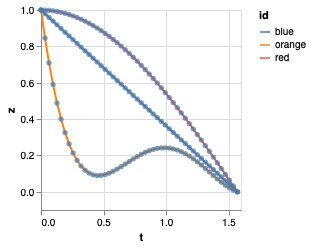

In [17]:
(-> (points-tz->plot plot-3)
    kind/vega-lite)

Show that your numerically attained harmonic-path approximates the well known analytic solution.

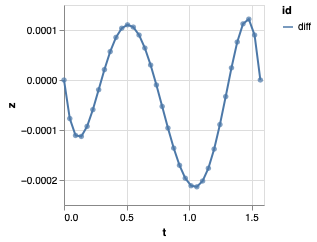

In [18]:
(-> (points-tz->plot
     {"diff" 
      (make-path-tz #(- (cos %) (harmonic-path %)) 0 pi-half 35)})
    kind/vega-lite)

Calculate the Lagrange equation of the harmonic oszillator.

In [19]:
(tex$$ (((Lagrange-equations (lg/L-harmonic 'm 'k)) (literal-function 'q)) 't))

$$k\,q\left(t\right) + m\,{D}^{2}q\left(t\right)$$

## 1.5 The Euler-Lagrange Equations

### 1.5.2 Computing Lagrange's Equations

#### The free particle

State the dynamic equation of motion (i.e. the Lagrange equation a.k.a Newton's second law) of the free particle.

In [20]:
(tex$$ (((Lagrange-equations (lg/L-free-particle 'm)) (literal-function 'q)) 't))

$$m\,{D}^{2}q\left(t\right)$$

Check that an arbitrary straight-line path satisfies this equation, i.e. that inserting a straight line for $q(t)$ gives identically zero (strictly speaking the zero covector of three dimensions).

In [21]:
(letfn [(straight-line [t]
  (up (+ (* 'a t) 'a0)
    (+ (* 'b t) 'b0)
    (+ (* 'c t) 'c0)))]
   (tex$$ (((Lagrange-equations (lg/L-free-particle 'm)) straight-line) 't)))

$$\begin{bmatrix}\displaystyle{0}&\displaystyle{0}&\displaystyle{0}\end{bmatrix}$$

#### The harmonic oscillator

State the dynamic equation of motion for the harmonic oszillator with arbitrary mass and spring constant.

In [22]:
(tex$$ (((Lagrange-equations (lg/L-harmonic 'm 'k)) (literal-function 'q)) 't))

$$k\,q\left(t\right) + m\,{D}^{2}q\left(t\right)$$

Plug in a sinusoid with arbitrary amplitude $A$, frequency $\omega$ and phase $\phi$ and show that the only solutions allowed are ones where $\omega = \sqrt{k/m}$ 

In [23]:
(letfn [(proposed-solution [t]
  (* 'A (cos (+ (* 'omega t) 'φ))))]
  (tex$$ (((Lagrange-equations (lg/L-harmonic 'm 'k)) proposed-solution) 't)))

$$- A\,m\,{\omega}^{2}\,\cos\left(\omega\,t + \phi\right) + A\,k\,\cos\left(\omega\,t + \phi\right)$$

#### Exercise 1.11: Kepler's third law

Show that a planet in circular orbit satisfies Kepler's third law $n^2a^3=G(M_1+m_2)$, where $n$ is the angular frequency of the orbit and $a$ is the distance between sun and planet. (Hint: use the reduced mass to construct the Lagrangian)

In [24]:
(defn gravitational-energy [G M_1 m_2]
  (fn [r]
   (- (/ (* G M_1 m_2) r))))

(defn circle [t]
  (up 'a (* 'n t)))

(let [lagrangian (lg/L-central-polar     
                  (/ (* 'M_1 'm_2) (+ 'M_1 'm_2))     
                  (gravitational-energy 'G 'M_1 'm_2))]
      (tex$$ (((Lagrange-equations lagrangian) circle) 't)))

$$\begin{bmatrix}\displaystyle{\frac{- M_1\,{a}^{3}\,m_2\,{n}^{2} + G\,{M_1}^{2}\,m_2 + G\,M_1\,{m_2}^{2}}{M_1\,{a}^{2} + {a}^{2}\,m_2}}&\displaystyle{0}\end{bmatrix}$$

## 1.6 How to find Lagrangians

#### Central force field

State the dynamic equation of motion for the uniform acceleration and the central potential, the latter in rectangular as well as in polar coordinates.

In [25]:
(tex$$ (up
           (((Lagrange-equations
              (lg/L-uniform-acceleration 'm 'g))
            (up (literal-function 'x)
              (literal-function 'y)))
           't)
           
           (((Lagrange-equations
              (lg/L-central-rectangular 'm (literal-function 'U)))
            (up (literal-function 'x)
              (literal-function 'y)))
           't)
           
           (((Lagrange-equations
              (lg/L-central-polar 'm (literal-function 'U)))
            (up (literal-function 'r)
              (literal-function 'phi)))
           't)))

$$\begin{pmatrix}\displaystyle{\begin{bmatrix}\displaystyle{m\,{D}^{2}x\left(t\right)}&\displaystyle{g\,m + m\,{D}^{2}y\left(t\right)}\end{bmatrix}} \cr \cr \displaystyle{\begin{bmatrix}\displaystyle{\frac{m\,{D}^{2}x\left(t\right)\,\sqrt {{\left(x\left(t\right)\right)}^{2} + {\left(y\left(t\right)\right)}^{2}} + x\left(t\right)\,DU\left(\sqrt {{\left(x\left(t\right)\right)}^{2} + {\left(y\left(t\right)\right)}^{2}}\right)}{\sqrt {{\left(x\left(t\right)\right)}^{2} + {\left(y\left(t\right)\right)}^{2}}}}&\displaystyle{\frac{m\,{D}^{2}y\left(t\right)\,\sqrt {{\left(x\left(t\right)\right)}^{2} + {\left(y\left(t\right)\right)}^{2}} + y\left(t\right)\,DU\left(\sqrt {{\left(x\left(t\right)\right)}^{2} + {\left(y\left(t\right)\right)}^{2}}\right)}{\sqrt {{\left(x\left(t\right)\right)}^{2} + {\left(y\left(t\right)\right)}^{2}}}}\end{bmatrix}} \cr \cr \displaystyle{\begin{bmatrix}\displaystyle{- m\,r\left(t\right)\,{\left(D\phi\left(t\right)\right)}^{2} + m\,{D}^{2}r\left(t\right) + DU\left(r\left(t\right)\right)}&\displaystyle{m\,{\left(r\left(t\right)\right)}^{2}\,{D}^{2}\phi\left(t\right) + 2\,m\,r\left(t\right)\,D\phi\left(t\right)\,Dr\left(t\right)}\end{bmatrix}}\end{pmatrix}$$

### 1.6.1 Coordinate transformations

Calculate the $[\dot x \space \dot y]$ velocity vector in polar coordinates.

In [26]:
(tex$$ (velocity ((F->C p->r) (->local 't (up 'r 'φ) (up 'rdot 'φdot)))))

$$\begin{pmatrix}\displaystyle{- r\,\dot {\phi}\,\sin\left(\phi\right) + \dot r\,\cos\left(\phi\right)} \cr \cr \displaystyle{r\,\dot {\phi}\,\cos\left(\phi\right) + \dot r\,\sin\left(\phi\right)}\end{pmatrix}$$

Calculate the lagrangian in polar coordinates twice. Once directly and once via the lagrangian in rectangular coordinates.

In [27]:
(defn L-alternate-central-polar
  [m U]
  (compose (lg/L-central-rectangular m U) (F->C p->r)))

(tex$$
 (let [lcp ((lg/L-central-polar 'm (literal-function 'U))
            (->local 't (up 'r 'φ) (up 'rdot 'φdot)))
       lacp ((L-alternate-central-polar 'm (literal-function 'U))
             (->local 't (up 'r 'φ) (up 'rdot 'φdot)))]
   (up lcp lacp)))

$$\begin{pmatrix}\displaystyle{\frac{1}{2}\,m\,{r}^{2}\,{\dot {\phi}}^{2} + \frac{1}{2}\,m\,{\dot r}^{2} - U\left(r\right)} \cr \cr \displaystyle{\frac{1}{2}\,m\,{r}^{2}\,{\dot {\phi}}^{2} + \frac{1}{2}\,m\,{\dot r}^{2} - U\left(r\right)}\end{pmatrix}$$

#### Coriolis and centrifugal forces

State, in cartesian coordinates, the Lagrangian for the two dimensional free particle in a rotating coordinate system.

In [28]:
(def L-free-rectangular lg/L-free-particle)

(defn L-free-polar [m]
 (compose (L-free-rectangular m) (F->C p->r)))

(defn F [Omega]
 (fn [[t [r theta]]]
  (up r (+ theta (* Omega t)))))

(defn L-rotating-polar [m Omega]
 (compose (L-free-polar m) (F->C (F Omega))))

(defn r->p
  "rectangular to polar coordinates of state."
  [[_ [x y :as q]]]
  (up (sqrt (square q)) (atan (/ y x))))

(defn L-rotating-rectangular [m Omega]
  (compose (L-rotating-polar m Omega) (F->C r->p)))

(tex$$ ((L-rotating-rectangular 'm 'Omega) (up 't (up 'x_r 'y_r) (up 'xdot_r 'ydot_r))))

$$\frac{1}{2}\,{\Omega}^{2}\,m\,{x_r}^{2} + \frac{1}{2}\,{\Omega}^{2}\,m\,{y_r}^{2} + \Omega\,m\,x_r\,{\dot y}_r - \Omega\,m\,{\dot x}_r\,y_r + \frac{1}{2}\,m\,{{\dot x}_r}^{2} + \frac{1}{2}\,m\,{{\dot y}_r}^{2}$$

In [29]:
;; speed up calculation
(defmacro Lrrsm []
  (list 'fn ['m 'Omega]
        (list 'fn [['t ['x_r 'y_r] ['xdot_r 'ydot_r]]]
              (clojure.edn/read-string
               (prn-str
                (simplify ((L-rotating-rectangular 'm 'Omega)
                           (up 't (up 'x_r 'y_r) (up 'xdot_r 'ydot_r)))))))))

(def L-rotating-rectangular-simp (Lrrsm))

(tex$$ ((L-rotating-rectangular-simp 'm 'Omega) (up 't (up 'x_r 'y_r) (up 'xdot_r 'ydot_r))))

$$\frac{1}{2}\,{\Omega}^{2}\,m\,{x_r}^{2} + \frac{1}{2}\,{\Omega}^{2}\,m\,{y_r}^{2} + \Omega\,m\,x_r\,{\dot y}_r - \Omega\,m\,{\dot x}_r\,y_r + \frac{1}{2}\,m\,{{\dot x}_r}^{2} + \frac{1}{2}\,m\,{{\dot y}_r}^{2}$$

Derive the equations of motion, in which the centrifugal and the coriolis force appear.

In [30]:
(tex$$
  (((Lagrange-equations (L-rotating-rectangular 'm 'Omega))
     (up (literal-function 'x_r) (literal-function 'y_r)))
     't))

$$\begin{bmatrix}\displaystyle{- {\Omega}^{2}\,m\,x_r\left(t\right) - 2\,\Omega\,m\,Dy_r\left(t\right) + m\,{D}^{2}x_r\left(t\right)}&\displaystyle{- {\Omega}^{2}\,m\,y_r\left(t\right) + 2\,\Omega\,m\,Dx_r\left(t\right) + m\,{D}^{2}y_r\left(t\right)}\end{bmatrix}$$

In [31]:
;; this is much faster
(tex$$
  (((Lagrange-equations (L-rotating-rectangular-simp 'm 'Omega))
     (up (literal-function 'x_r) (literal-function 'y_r)))
     't))

$$\begin{bmatrix}\displaystyle{- {\Omega}^{2}\,m\,x_r\left(t\right) - 2\,\Omega\,m\,Dy_r\left(t\right) + m\,{D}^{2}x_r\left(t\right)}&\displaystyle{- {\Omega}^{2}\,m\,y_r\left(t\right) + 2\,\Omega\,m\,Dx_r\left(t\right) + m\,{D}^{2}y_r\left(t\right)}\end{bmatrix}$$

Plot a clockwise rotating path. (Hints: (1) Use the SICM function "Gamma" to create the triple $(t \: (x \: y) \: (\dot{x} \: \dot{y}))$ which can be transformed, (2) the angular frequency must be negative)

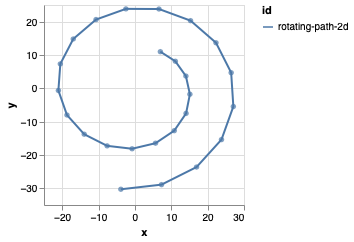

In [32]:
(defn test-path-2d
  [t]
  (up
   (+ (* 3 t) 7)
   (+ (* 5 t) 11)))

(defmacro rpm []
  (list 'fn ['Omega 't]
        (clojure.edn/read-string
         (prn-str
          (simplify
           ((F->C p->r)
            ((F->C (F 'Omega))
             ((F->C r->p)
              ((Gamma test-path-2d) 't)))))))))

(def rotate-path (rpm))

(defn rotating-path-2d [Omega]
  (up (fn [t] (get-in (rotate-path Omega t) [1 0]))
      (fn [t] (get-in (rotate-path Omega t) [1 1]))))

(let [NegativeOm -3]
    (-> (points-xy->plot {"rotating-path-2d" (make-path-txyz (rotating-path-2d NegativeOm) 0 3 25)})
        kind/vega-lite))

Show that this path indeed satiesfies the equations of motion in a rotating coordinate system.

In [33]:
(simplify
   (let [Om 'Omega
         NegativeOm (* -1 Om)]
     (((Lagrange-equations (L-rotating-rectangular-simp 'm Om))
       (rotating-path-2d NegativeOm))
      't)))

0 0

### 1.6.2 Systems with rigid constraints

#### A pendulum driven at the pivot

State Lagrange’s equation for this system.

In [34]:
(defn T-pend
  [m l _ ys]
  (fn [local]
    (let [[t theta thetadot] local
          vys (D ys)]
      (* 1/2 m
         (+ (square (* l thetadot))
            (square (vys t))
            (* 2 l (vys t) thetadot (sin theta)))))))

(defn V-pend
  [m l g ys]
  (fn [local]
    (let [[t theta _] local]
      (* m g (- (ys t) (* l (cos theta)))))))

(def L-pend (- T-pend V-pend))

(def θ (literal-function 'θ))
(def y_s (literal-function 'y_s))

(tex$$
  (((Lagrange-equations (L-pend 'm 'l 'g y_s)) θ) 't))

$$g\,l\,m\,\sin\left(\theta\left(t\right)\right) + {l}^{2}\,m\,{D}^{2}\theta\left(t\right) + l\,m\,\sin\left(\theta\left(t\right)\right)\,{D}^{2}y_s\left(t\right)$$

State the Lagrangian

In [35]:
(tex$$
  ((L-pend 'm 'l 'g y_s) (->local 't 'θ 'θdot)))

$$\frac{1}{2}\,{l}^{2}\,m\,{\dot {\theta}}^{2} + l\,m\,\dot {\theta}\,Dy_s\left(t\right)\,\sin\left(\theta\right) + g\,l\,m\,\cos\left(\theta\right) - g\,m\,y_s\left(t\right) + \frac{1}{2}\,m\,{\left(Dy_s\left(t\right)\right)}^{2}$$

### 1.6.3 Constraints as Coordinate Transformations

Derive the previous result by using coordinate transformations.

In [36]:
(defn L-uniform-acceleration [m g]
  (fn [[_ [_ y] v]]
    (- (* 1/2 m (square v)) (* m g y))))

(defn dp-coordinates [l y_s]
  (fn [[t θ]]
    (let [x (* l (sin θ))
          y (- (y_s t) (* l (cos θ)))]
      (up x y))))

(defn L-pend2 [m l g y_s]
  (comp (L-uniform-acceleration m g)
        (F->C (dp-coordinates l y_s))))
(tex$$
        ((L-pend2 'm 'l 'g y_s) (->local 't 'θ 'θdot)))

$$\frac{1}{2}\,{l}^{2}\,m\,{\dot {\theta}}^{2} + l\,m\,\dot {\theta}\,Dy_s\left(t\right)\,\sin\left(\theta\right) + g\,l\,m\,\cos\left(\theta\right) - g\,m\,y_s\left(t\right) + \frac{1}{2}\,m\,{\left(Dy_s\left(t\right)\right)}^{2}$$

### 1.8.3 Central Forces in Three Dimensions

Calculate the z-component of the angular momentum of an arbitrary path in rectangular and spherical coordinates.

In [37]:
(def rectangular-state (up 't
                           (up 'x 'y 'z)
                           (up 'xdot 'ydot 'zdot)))

(def spherical-state (up 't
                         (up 'r 'θ 'φ)
                         (up 'rdot 'θdot 'φdot)))

(defn ang-mom-z [m]
  (fn [[_ xyz v]]
    (get (cross-product xyz (* m v)) 2)))

(tex$$
  (up
    ((ang-mom-z 'm) rectangular-state)
    ((compose (ang-mom-z 'm) (F->C s->r)) spherical-state)))

$$\begin{pmatrix}\displaystyle{m\,x\,\dot y - m\,\dot x\,y} \cr \cr \displaystyle{m\,{r}^{2}\,\dot {\phi}\,{\sin}^{2}\left(\theta\right)}\end{pmatrix}$$

Using sherical coordinates, calculate the generalized forces and the generalized momenta of a planet moving in a central potential. Thus show that the momentum conjugate to the third coordinate $\phi$ is (1) conserved (because the respective force is zero) and (2) identical the z-component of the angular momentum.

In [38]:
(def V (literal-function 'V))

(defn T3-spherical [m]
 (compose (L-free-rectangular m) (F->C s->r)))

(defn L3-central [m Vr]
  (let [Vs (fn [[_ [r]]] (Vr r))]
    (- (T3-spherical m) Vs)))

(tex$$
  (up
    (((partial 1) (L3-central 'm V)) spherical-state)
    (((partial 2) (L3-central 'm V)) spherical-state)))

$$\begin{pmatrix}\displaystyle{\begin{bmatrix}\displaystyle{m\,r\,{\dot {\phi}}^{2}\,{\sin}^{2}\left(\theta\right) + m\,r\,{\dot {\theta}}^{2} - DV\left(r\right)}&\displaystyle{m\,{r}^{2}\,{\dot {\phi}}^{2}\,\sin\left(\theta\right)\,\cos\left(\theta\right)}&\displaystyle{0}\end{bmatrix}} \cr \cr \displaystyle{\begin{bmatrix}\displaystyle{m\,\dot r}&\displaystyle{m\,{r}^{2}\,\dot {\theta}}&\displaystyle{m\,{r}^{2}\,\dot {\phi}\,{\sin}^{2}\left(\theta\right)}\end{bmatrix}}\end{pmatrix}$$

Show that the energy state function computed from the Lagrangian for a central field is in fact T + V.

In [39]:
(tex$$
  (up  
    ((T3-spherical 'm) (->local 't (up 'r 'θ 'φ) (up 'rdot 'θdot 'φdot)))
    ((Lagrangian->energy (L3-central 'm V)) spherical-state)))

$$\begin{pmatrix}\displaystyle{\frac{1}{2}\,m\,{r}^{2}\,{\dot {\phi}}^{2}\,{\sin}^{2}\left(\theta\right) + \frac{1}{2}\,m\,{r}^{2}\,{\dot {\theta}}^{2} + \frac{1}{2}\,m\,{\dot r}^{2}} \cr \cr \displaystyle{\frac{1}{2}\,m\,{r}^{2}\,{\dot {\phi}}^{2}\,{\sin}^{2}\left(\theta\right) + \frac{1}{2}\,m\,{r}^{2}\,{\dot {\theta}}^{2} + \frac{1}{2}\,m\,{\dot r}^{2} + V\left(r\right)}\end{pmatrix}$$